In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from joblib import dump,load

Before starting the modeling process, we need to load the data and apply all the cleaning and feature engineering steps completed during the EDA phase. All of this is done in a single step by running the custom data_prep() function below.

In [2]:
def data_prep(df, 
              group_col, 
              agg_col,
              n_level,
              low_threshold, 
              medium_threshold, 
              drop_na_col = True,
              drop_duplicates_col = True,
              log_transform = True,
              mileage_outliers = True):
  
    '''
    
    This function simplifies data preparation by:
    1. Extracting year from Name and updating the Name column.
    2. Converting specified columns to numeric, cleaning non-numeric characters.
    3. Droping any na's in the Target, duplcates rows, transforming the Target to Log, and removes potential outliers
    4. Grouping and categorizing rows based on aggregation statistics of the agg_col.
    It returns a clean data with the mapping_dict to group some levels if needed as the DataPrepResult class.
    
    '''

    #Step1:
    df['Year'] = df[group_col].str[:4]
    df[group_col] = df[group_col].str[5:]
    
    #Step2:
    col_name_convert = ['Mileage', 'Review Count', 'Price', 'Year']
    
    for col in col_name_convert:
        df[col] = pd.to_numeric(df[col].str.replace(r'\D', '', regex = True), errors = 'coerce')
    

    #Step3:
    
    # Drop rows with missing values in the agg_col column, drop_na_col = True
    if drop_na_col:
        df = df.dropna(subset = agg_col)
    
    
    if drop_duplicates_col:
        df = df.drop_duplicates()
        
    # Apply log transformation to the target variable
    if log_transform:
        df['Log_Price'] = np.log(df[agg_col])
        
    # Removing the potential outliers by setting Mileage less than 125,000
    if mileage_outliers:
        df = df[df['Mileage'] < 125000]
    
    
    #Step4:

    # Group by the specified column and calculate count and average of the aggregation column
    df_group = df.groupby(group_col).agg(
        Name_Count=(group_col, 'count'),
        Avg_Agg_Value=(agg_col, 'mean')
    ).reset_index()

    # Categorize based on thresholds
    df_group.loc[(df_group['Name_Count'] <= n_level) & (df_group['Avg_Agg_Value'] <= low_threshold), 'Adj_Name'] = 'Other_Low'
    df_group.loc[(df_group['Name_Count'] <= n_level) & (df_group['Avg_Agg_Value'] > low_threshold) & 
                 (df_group['Avg_Agg_Value'] <= medium_threshold), 'Adj_Name'] = 'Other_Medium'
    df_group.loc[(df_group['Name_Count'] <= n_level) & (df_group['Avg_Agg_Value'] > medium_threshold), 'Adj_Name'] = 'Other_High'
    df_group.loc[df_group['Name_Count'] > n_level, 'Adj_Name'] = df_group[group_col]

    # Merge the aggregated results back to the original DataFrame
    df = df.merge(df_group, on = group_col)
    
    # Create a mapping dictionary for future use when we will have new unseen data.
    mapping_dict = dict(zip(df['Name'], df['Adj_Name']))
    
    # Dropping the newly created columns that we don't need any more
    df = df.drop(columns = ['Name_Count', 'Avg_Agg_Value', 'Adj_Name'], axis = 1)

    # Return the result as a custom object
    return df, mapping_dict

In [3]:
benz = pd.read_csv("data/usa_mercedes_benz_prices.csv")
benz.head()

,Name,Mileage,Rating,Review Count,Price
0,2021 Mercedes-Benz A-Class A 220 4MATIC,"29,636 mi.",3.9,"1,800","$30,900"
1,2022 Mercedes-Benz AMG SL 63 Base,"5,540 mi.",4.7,"1,239","$139,999"
2,2022 Mercedes-Benz AMG SL 63 Base,"4,890 mi.",4.7,"1,239","$132,999"
3,2020 Mercedes-Benz AMG E 53 Base 4MATIC,"29,746 mi.",4.8,752,"$58,587"
4,2021 Mercedes-Benz AMG GLS 63 Base 4MATIC,"32,631 mi.",5.0,"1,502","$95,990"


In [4]:
benz, mapping_dict = data_prep(df = benz, 
                    group_col = 'Name', 
                    agg_col = 'Price',
                    n_level = 2,
                    low_threshold = 50000, 
                    medium_threshold = 100000)


benz.head()

,Name,Mileage,Rating,Review Count,Price,Year,Log_Price
0,Mercedes-Benz A-Class A 220 4MATIC,29636,3.9,1800.0,30900.0,2021,10.338511
1,Mercedes-Benz AMG SL 63 Base,5540,4.7,1239.0,139999.0,2022,11.849391
2,Mercedes-Benz AMG SL 63 Base,4890,4.7,1239.0,132999.0,2022,11.798097
3,Mercedes-Benz AMG E 53 Base 4MATIC,29746,4.8,752.0,58587.0,2020,10.978268
4,Mercedes-Benz AMG GLS 63 Base 4MATIC,32631,5.0,1502.0,95990.0,2021,11.471999


## 1 Train\Test Split

Due to the thin data issue, where some Name categories appear only once or twice, I will group these low-frequency categories to enable a stratified sampling approach based on the Name feature. This will ensure a more balanced 70/30 train-test split.

In [5]:
# Group Name categories with one and two occurances into Other_low, Other_medium, and Other_high 
benz['Name'] = benz['Name'].map(mapping_dict)

In [6]:
X = benz.drop(['Price', 'Log_Price'], axis = 1)
y = benz['Log_Price']

# Assume 'Name' is the column with thin levels in X and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify = X['Name'], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [7]:
X_train_num = X_train.drop('Name', axis = 1)
X_train_cat = X_train['Name']

num_attribs = X_train_num.columns
cat_attribs = ['Name']

## 2 Training 

As part of the model training process, I will first establish a baseline performance using Linear Regression, followed by training more advanced models such as Elastic Net, Random Forest, Gradient Boosting, and  XGBM.

### 2.1 Create classes for Categorical and numerical features

This class is designed to be automatically integrated into a pipeline, grouping the Name feature into predefined categories, even for new, unseen data. It ensures that any unseen categories are mapped into a default group, providing consistency in how the Name feature is handled during both training and prediction.

In [8]:
class AddCatFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, mapping_dict, add_Name = True):
        self.mapping_dict = mapping_dict
        self.add_Name = add_Name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        
        Name_ix = 0
        
        if isinstance(X, pd.Series):
            X = X.to_frame()  # Convert Series to DataFrame if necessary

        if self.add_Name:
            # Map the 'Name' column to 'New_Name' using the mapping dictionary
            X.iloc[:, Name_ix] = X.iloc[:, Name_ix].map(self.mapping_dict)

            # Handle missing values, if required
            X.iloc[:, Name_ix] = X.iloc[:, Name_ix].fillna('Not Mapped')

        return X  # Return the transformed DataFrame

This class automatically calculates newly engineered numerical features based on the input data. It transforms the raw input by applying the defined feature engineering logic, ensuring that the numerical features are consistently created and ready for use in the machine learning pipeline, both during training and prediction on new data.

In [9]:
class AddNumFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_New_Features = True):
        self.add_New_Features = add_New_Features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Mileage_ix, Rating_ix, Review_Count_ix, Year_ix = 0, 1, 2, 3
        
        if self.add_New_Features:
        
            # Set Review Count to 1 if it is 0 to avoid division by zero
            X.iloc[X.iloc[:, Review_Count_ix] == 0, Review_Count_ix] = 1

            # Threshold for minimum number of reviews
            m = 100
            # Global average rating across all products
            C = X.iloc[:, Rating_ix].mean()

            Credibility = ((X.iloc[:, Rating_ix] * X.iloc[:, Review_Count_ix]) + (C * m)) / (X.iloc[:, Review_Count_ix] + m)

            # Calculate the weighted average of Rating
            #WAvg_Rating = (X.iloc[:, Rating_ix] * X.iloc[:, Review_Count_ix]) / X.iloc[:, Review_Count_ix].sum()

            # Add Year Mileage interaction
            Mil_Year = X.iloc[:, Mileage_ix] * X.iloc[:, Year_ix]

            X = np.c_[X, Credibility, Mil_Year]

            X = np.delete(X, [Mileage_ix, Rating_ix, Review_Count_ix, Year_ix], axis=1)
        
        return X

This pipeline adds numerical features (if enabled), imputes missing values using the median, and scales the data to have zero mean and unit variance.

In [10]:
num_pipeline = Pipeline([
                         ('new_features', AddNumFeatures(add_New_Features = False)),
                         ('imputer', SimpleImputer(strategy="median")),
                         ('std_scaler', StandardScaler())
                            ])

This pipeline adds categorical features (if enabled), then applies one-hot encoding while dropping the first column to avoid multicollinearity.

In [11]:
cat_pipeline = Pipeline([
    ('adding_new_name', AddCatFeatures(mapping_dict, add_Name = False)),
    ('onehot', OneHotEncoder(drop='first'))      # One-hot encode with drop first column
])

This pipeline preprocesses numerical and categorical features: it imputes and scales numerical data, and adds features and one-hot encodes categorical data, all in one step using ColumnTransformer.

In [12]:
full_pipeline = ColumnTransformer([
                                    ("num", num_pipeline, num_attribs),
                                    ("cat", cat_pipeline, cat_attribs),
                                  ])

* X_train_prepared = full_pipeline.fit_transform(X_train): This applies the entire transformation pipeline (which includes handling numeric and categorical data) to the training data. The fit_transform part means that it learns from the training data (e.g., scales values, encodes categories) and then applies those transformations.

* X_test_prepared = full_pipeline.transform(X_test): This applies the same transformations (already learned from the training data) to the test data. Since it's only applying the transformations, it doesn't need to "learn" from the test data, so we use transform only.

In [13]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [14]:
num_columns = list(num_attribs) 

# Extract the feature names for categorical columns after the pipeline
cat_columns = full_pipeline.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_attribs)

# Combine numeric and categorical column names
all_columns = num_columns + list(cat_columns)


pd.DataFrame(X_train_prepared.toarray(), columns = all_columns)

,Mileage,Rating,Review Count,Year,Name_Mercedes-Benz A-Class A 220,Name_Mercedes-Benz A-Class A 220 4MATIC,Name_Mercedes-Benz AMG A 35 Base,Name_Mercedes-Benz AMG C 43 Base 4MATIC,Name_Mercedes-Benz AMG C 63 S,Name_Mercedes-Benz AMG CLA 35 4MATIC,...,Name_Mercedes-Benz S-Class S 500 4MATIC,Name_Mercedes-Benz S-Class S 560,Name_Mercedes-Benz S-Class S 560 4MATIC,Name_Mercedes-Benz S-Class S 580 4MATIC,Name_Mercedes-Benz SL 450 Base,Name_Mercedes-Benz SLC 300 Base,Name_Mercedes-Benz Sprinter 2500 Standard Roof,Name_Other_High,Name_Other_Low,Name_Other_Medium
0,-1.077916,0.150984,-1.010366,0.779882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.009526,0.150984,3.386907,-0.462591,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.620336,0.150984,-1.002384,0.779882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.993952,0.713315,-0.883452,-1.083828,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.040928,0.713315,0.392068,-1.083828,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,-0.941029,0.713315,0.373709,0.779882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1672,0.950221,0.150984,-0.960079,-0.462591,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1673,-1.058385,-0.692512,0.178949,0.779882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1674,0.509893,0.432149,-0.201791,-0.462591,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 Training The Five Models 

In [15]:
def adj_r2(X, y, pred):
    
    '''
    
    This function calculates the adjusted r_2
    
    '''
    
    # calculate R^2
    r2 = r2_score(y, pred)
    
    # Get the number of samples (n) and number of features (k)
    n, k = X.shape[0], X.shape[1]  
    # Calculate adjusted R-squared
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    
    return adj_r2

In [16]:
def evaluate_models(X_train, y_train, X_test, y_test, models, param):
    
    '''
    
    This function calculates the MAE, RMSE, and Adj_R2 for both Train and Test sets and for each model, 
    then return the results in Pandas DataFrame
    
    '''
    
    data = {}

    # Loop through models and their corresponding hyperparameters
    for model_name, model in models.items():
        # Get the hyperparameter grid for the current model
        para = param[model_name]

        # Perform GridSearchCV
        gs = GridSearchCV(model, para, cv=3)
        gs.fit(X_train, y_train)

        # Make predictions using the best model from GridSearchCV
        y_train_pred = gs.predict(X_train)
        y_test_pred = gs.predict(X_test)
        
        
        # Calculate the Mean Absolute Error
        train_MAE = mean_absolute_error(y_train, y_train_pred)
        test_MAE = mean_absolute_error(y_test, y_test_pred)
        
        # Calculate the Root Mean Square
        train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        # calculate Adjusted R^2
        train_adj_r2 = adj_r2(X_train, y_train, y_train_pred)
        test_adj_r2 = adj_r2(X_test, y_test, y_test_pred)
        
        # Add the results to the report dictionary for this model
        data[model_name] = {
                                'train_mae': train_MAE,
                                'train_rmse': train_RMSE,
                                'train_adj_r2': train_adj_r2,
                                'test_mae': test_MAE,
                                'test_rmse': test_RMSE,
                                'test_adj_r2': test_adj_r2
                                }
        
        # Now we take the dictionnary and create a nice data frame 
        # Create a MultiIndex for columns
        columns = pd.MultiIndex.from_tuples(
            [('train', 'MAE'), ('train', 'RMSE'), ('train', 'Adj_R2'), 
             ('test', 'MAE'), ('test', 'RMSE'), ('test', 'Adj_R2')],
            names = ['set', 'metric']
        )
        
        # Create a DataFrame from the data
        report = pd.DataFrame(
            {('train', 'MAE'): [data[model]['train_mae'] for model in data],
             ('train', 'RMSE'): [data[model]['train_rmse'] for model in data],
             ('train', 'Adj_R2'): [data[model]['train_adj_r2'] for model in data],
             ('test', 'MAE'): [data[model]['test_mae'] for model in data],
             ('test', 'RMSE'): [data[model]['test_rmse'] for model in data],
             ('test', 'Adj_R2'): [data[model]['test_adj_r2'] for model in data]
            },
            index = data.keys(),
            columns = columns
        )
        

    return report

Defining the models and params of each model

In [17]:
models = {
            "Linear Regression": LinearRegression(),
            "Elastic net Regression": ElasticNet(),
            "Random Forest": RandomForestRegressor(),
            "Gradient Boosting": GradientBoostingRegressor(),
            "XGBRegressor": XGBRegressor()
            }

params = {
            "Linear Regression":{
                
                                    },
    
            "Elastic net Regression":{
                                        'alpha':[0.1,0.5,1,2,5],
                                        'l1_ratio':[0.1,0.5,1]
                                        },

            "Random Forest":{
                                'n_estimators': [3, 10, 30],
                                'max_features': [2, 4, 6, 8]
                                },
    
            "Gradient Boosting":{
                                    'n_estimators': [100, 200, 300],        # Number of trees
                                    'learning_rate': [0.01, 0.05, 0.1]     # Step size shrinkage
                                    },
    
            "XGBRegressor":{
                                'n_estimators': [100, 200, 300],        # Number of trees
                                'learning_rate': [0.01, 0.05, 0.1]     # Step size shrinkage
                                },
            }


#### 1. Linear Regression Model:
Linear Regression models the relationship between input features (X) and a target variable (y) by fitting a straight line to the data. It minimizes the difference between predicted and actual values. This method is simple to interpret but may struggle with non-linear relationships or outliers.

#### 2. Elastic Net Model:
Elastic Net is a method for making predictions that balances two techniques: one that simplifies the model by removing unnecessary features and another that prevents overfitting. It’s especially useful when there are many related features, helping the model perform better on complex data.

#### 3. Random Forest Model:
Random Forest is an ensemble algorithm that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting. At each split, it randomly selects m features rather than using all features, which reduces correlation between trees. Final predictions are made by averaging (regression) or majority voting (classification), making the model more robust and less prone to overfitting.

#### 4. Gradient Boosting Model:
Gradient Boosting is an ensemble algorithm that builds decision trees sequentially, with each tree correcting the errors of the previous ones. It refines predictions by focusing on the hardest-to-predict instances, making it effective for regression and classification. Final predictions are a weighted sum of all trees.

#### 5. XGBRegressor Model:
XGBRegressor is a powerful implementation of Gradient Boosting designed specifically for regression tasks. It builds trees sequentially, where each tree corrects the errors of the previous ones, and it optimizes model performance using advanced techniques like regularization to prevent overfitting. XGBRegressor is efficient, handles large datasets well, and supports features like early stopping and parallel processing, making it highly popular for regression problems.

In [18]:
error_table = evaluate_models(X_train = X_train_prepared,
                y_train = y_train,
                X_test = X_test_prepared,
                y_test = y_test,
                models = models,
                param = params)

error_table 

c:\Users\ahmed\Desktop\ML_Projects\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


set                        train                          test            \
metric                       MAE      RMSE    Adj_R2       MAE      RMSE   
Linear Regression       0.064937  0.094400  0.947686  0.073010  0.107703   
Elastic net Regression  0.295404  0.384494  0.132121  0.299857  0.392730   
Random Forest           0.046540  0.072467  0.969171  0.129503  0.190925   
Gradient Boosting       0.095555  0.122183  0.912359  0.110939  0.147783   
XGBRegressor            0.062067  0.084640  0.957943  0.092613  0.130635   

set                               
metric                    Adj_R2  
Linear Regression       0.925976  
Elastic net Regression  0.015755  
Random Forest           0.767384  
Gradient Boosting       0.860632  
XGBRegressor            0.891098

In [19]:
error_table['test', 'Adj_R2'].idxmax()

'Linear Regression'

Since I’m modeling the logarithm of Price (Log_Price) rather than Price directly, the test Adjusted R² is a more meaningful metric for evaluation. Among the models tested, Linear Regression stands out with the best test performance, achieving the highest Adjusted R² of 0.92 and low error metrics. The XGBRegressor follows closely, with an Adjusted R² of 0.89.

Both Gradient Boosting and Random Forest also performed well, demonstrating balanced results across the training and test sets. In contrast, Elastic Net underperformed, showing a significantly lower Adjusted R² on both the train and test sets.

Overall, Linear Regression emerges as the most effective model for this dataset.

### 2.3 Model Validation

The best performing model is the Linear Regression Model

#### 2.3.1 Cross-Validation

We perform cross-validation on the best-performing model (Linear Regression) to ensure consistent performance across different data splits.

In [20]:
# Perform k-fold cross-validation 
lr_model = LinearRegression()
cv_scores = cross_val_score(lr_model, 
                            X_train_prepared, 
                            y_train, 
                            cv = 5, 
                            scoring = 'neg_mean_squared_error')

# Convert negative MSE to positive
cv_rmse = np.sqrt(-cv_scores)

# Print the results
print("Cross-Validation RMSE scores: ", np.round(cv_rmse, 4))
print("Mean RMSE: ", np.round(cv_rmse.mean(), 4))
print("Standard Deviation of RMSE: ", np.round(cv_rmse.std(), 4))

Cross-Validation RMSE scores:  [0.0955 0.1003 0.0995 0.114  0.1125]
Mean RMSE:  0.1044
Standard Deviation of RMSE:  0.0074


The cross-validation results for the Linear Regression model indicate strong and consistent performance. The RMSE scores across the 5 folds are relatively low, with a mean RMSE of 0.1039, indicating that the model makes small prediction errors on average. The low standard deviation of 0.0085 suggests that the model's performance is stable across different subsets of the data, showing minimal variation in error across the folds. This consistency reinforces the reliability of the model's predictions.

#### 2.3.2 Evaluate on the Test Set

In [21]:
lr_model.fit(X_train_prepared,y_train)

train_pred = lr_model.predict(X_train_prepared)

test_pred = lr_model.predict(X_test_prepared)

In [22]:
# Calculate the Train Error Metrics
MAE_train = mean_absolute_error(y_train, train_pred)
RMSE_train = np.sqrt(mean_squared_error(y_train, train_pred))
adj_r2_train = adj_r2(X_train_prepared, y_train, train_pred)


# Calculate the Test Error Metrics
MAE_test = mean_absolute_error(y_test, test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, test_pred))
adj_r2_test = adj_r2(X_test_prepared, y_test, test_pred)

print(f'Train MAE: {MAE_train}\nTrain RMSE: {RMSE_train}\nTrain adj_R2: {adj_r2_train}\n\n')
print(f'Test MAE: {MAE_test}\nTest RMSE: {RMSE_test}\nTest adj_R2: {adj_r2_test}')    

Train MAE: 0.06493729217812733
Train RMSE: 0.09439977255719648
Train adj_R2: 0.9476855082331996


Test MAE: 0.07300994617245228
Test RMSE: 0.10770335574857771
Test adj_R2: 0.9259759294683486


* Adjusted R² reflects the explained variance of the model while adjusting for the number of predictors, ensuring a more accurate measure by penalizing unnecessary features.
* For the best model, Linear Regression, the test Adjusted R² is 0.92, meaning it captures 92% of the variation in the target variable.

#### 2.3.3 Residual Analysis and  Visual 

''

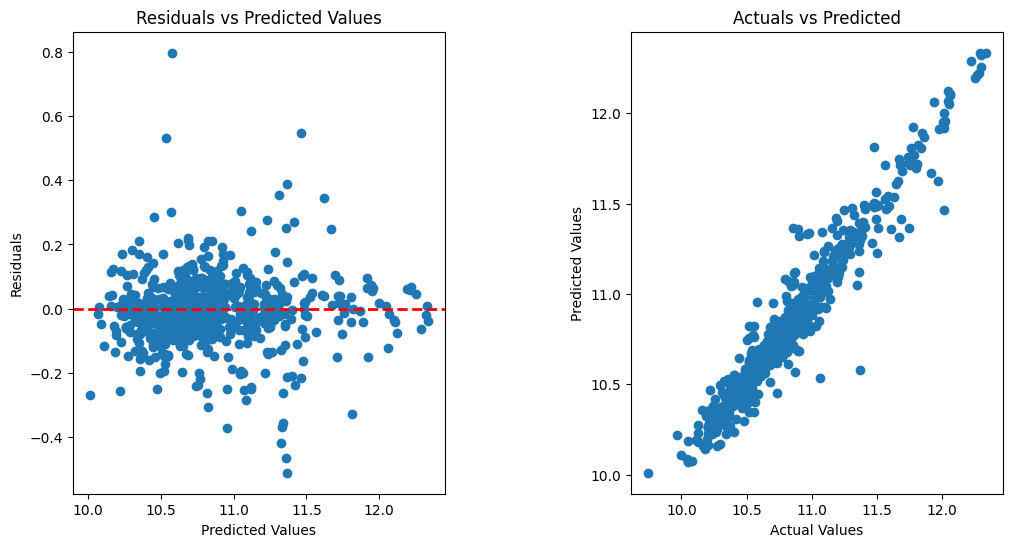

In [23]:
residuals = y_test - test_pred

# 4. Plot residuals
plt.figure(figsize = (12, 6))

# Scatter plot of residuals
plt.subplot(1, 2, 1)
plt.scatter(test_pred, residuals)
plt.axhline(0, color = 'r', linestyle ='--', linewidth = 2)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Scatter plot of actual vs predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test, test_pred)
plt.title('Actuals vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Adjust the space between subplots
plt.subplots_adjust(wspace = 0.5)
;

#### Residuals vs Predicted Values:

* No significant heteroscedasticity: The residuals appear to be randomly scattered around the horizontal line at zero, indicating that the variance of the errors is relatively constant across different predicted values.

#### Actuals vs Predicted:

* Linear relationship: The points follow a reasonably linear trend, suggesting that the model is accurately capturing the underlying relationship between the variables.
* Some scatter: There is some scatter around the line, indicating that there might be some room for improvement in the model's accuracy.

## 3 Model Saving

In [24]:
# Fitting the final model on all the dataset
X_prepared = full_pipeline.fit_transform(X)

final_model = LinearRegression()
final_model.fit(X_prepared, y)

#Saving the Poly Convertor and the Final Model
#dump(final_model,'final_benz_price_lr_model.joblib')

#Loading the Model
#loaded_model = load('final_benz_price_lr_model.joblib')

['final_benz_price_lr_model.joblib']